In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from config import api_key

In [2]:
from census import Census
from us import states

In [3]:
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels

# Census data
* As only civilians are legel to vote, it would make sense to only pull the civilian employment data.
* The labor force is the sum of employed and unemployed persons
* Columns data to pull: 
* Income variables: 
    "income": B19013_001E, "income_per_capita": B19301_001E
* Employment variables:
    "employable civilians": B23025_003E, "employed civilians": B23025_004E, "unemployed civilians": B23025_005E
* Population variables: 
    "Total population": B01003_001E
* Poverty variables:
    "poverty people": "B17001_002E"
    #"poverty_family": "B17012_002E"
    
* Age variables:
    "median age": "B01002_001E" 

In [6]:
# Census API calls
c = Census(api_key, year=2016)
raw_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B23025_003E',
                       'B23025_004E', 'B23025_005E', 'B01003_001E', "B01002_001E", "B17001_002E"), {'for':'state:*'})
census_df_raw = pd.DataFrame(raw_data)
census_df_raw = census_df_raw.rename(columns = {'state': 'State#',
                          'NAME': 'State', 
                          'B01003_001E':'Total_population',
                          'B23025_003E':'Employable_civilians',
                          'B23025_004E':'Employed_civilians', 
                          'B23025_005E':'Unemployed_civilians', 
                          'B19013_001E':'Income_median',
                          'B19301_001E':'Income_per_capita',
                          "B01002_001E":'median age',
                          "B17001_002E":'Poverty_count'    
})
census_df_raw = census_df_raw.sort_values('State#').reset_index(drop=True)
# census_df_raw = census_df_raw[['State', 'Total_population','Income_per_capita', 'Employable_civilians', 'Unemployed_civilians','Poverty_count'  ]]
census_df_raw.head()

,State,Income_median,Income_per_capita,Employable_civilians,Employed_civilians,Unemployed_civilians,Total_population,median age,Poverty_count,State#
0,Alabama,44758.0,24736.0,2226504.0,2042025.0,184479.0,4841164.0,38.6,868666.0,01
1,Alaska,74444.0,34191.0,384093.0,353954.0,30139.0,736855.0,33.6,72826.0,02
2,Arizona,51340.0,26686.0,3129344.0,2879372.0,249972.0,6728577.0,37.1,1165636.0,04
3,Arkansas,42336.0,23401.0,1359742.0,1266552.0,93190.0,2968472.0,37.7,542431.0,05
4,California,63783.0,31458.0,19260868.0,17577142.0,1683726.0,38654206.0,36.0,6004257.0,06


In [7]:
# Making a summary table 
census_df = census_df_raw.loc[:,['State', 'Total_population', 'Income_median', 'Income_per_capita']]
census_df['Poverty_rate'] = census_df_raw.Poverty_count/census_df_raw.Total_population
census_df['Unemployment_rate'] = census_df_raw.Unemployed_civilians/census_df_raw.Employable_civilians
state_df = pd.read_csv('Resources/state_centroids.csv')
census_df = pd.merge(census_df, state_df, on = 'State')
census_df = census_df.set_index('State')
census_df.head()

,Total_population,Income_median,Income_per_capita,Poverty_rate,Unemployment_rate,Latitude,Longitude
State,,,,,,,
Alabama,4841164.0,44758.0,24736.0,0.179433,0.082856,32.7794,-86.8287
Alaska,736855.0,74444.0,34191.0,0.098834,0.078468,64.0685,-152.2782
Arizona,6728577.0,51340.0,26686.0,0.173237,0.079880,34.2744,-111.6602
Arkansas,2968472.0,42336.0,23401.0,0.182731,0.068535,34.8938,-92.4426
California,38654206.0,63783.0,31458.0,0.155333,0.087417,37.1841,-119.4696


# Vote data

In [41]:
csvfile = 'Resources/1976-2016-president.tab'
vote_df = pd.read_csv(csvfile, sep='\t', header=(0))
vote_df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
2,1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN
3,1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin \\""Ben\""\""""",prohibition,False,6669,1182850,20171015,NaN
4,1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN


In [59]:
vote_df.loc[(vote_df.year == 2016)&(vote_df.party == 'democrat')]

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
3396,2016,Alabama,AL,1,63,41,US President,"Clinton, Hillary",democrat,False,729547,2123372,20171015,NaN
3401,2016,Alaska,AK,2,94,81,US President,"Clinton, Hillary",democrat,False,116454,318608,20171015,NaN
3408,2016,Arizona,AZ,4,86,61,US President,"Clinton, Hillary",democrat,False,1161167,2573165,20171015,NaN
3414,2016,Arizona,AZ,4,86,61,US President,NaN,democrat,True,42,2573165,20171015,NaN
3418,2016,Arkansas,AR,5,71,42,US President,"Clinton, Hillary",democrat,False,380494,1130635,20171015,NaN
3425,2016,California,CA,6,93,71,US President,"Clinton, Hillary",democrat,False,8753788,14181595,20171015,NaN
3431,2016,Colorado,CO,8,84,62,US President,"Clinton, Hillary",democrat,False,1338870,2780220,20171015,NaN
3451,2016,Connecticut,CT,9,16,1,US President,"Clinton, Hillary",democrat,False,897572,1644920,20171015,NaN
3456,2016,Delaware,DE,10,51,11,US President,"Clinton, Hillary",democrat,False,235603,441590,20171015,NaN
3460,2016,District of Columbia,DC,11,53,55,US President,"Clinton, Hillary",democrat,False,282830,312575,20171015,NaN


In [54]:
vote_df_2016_demo = vote_df.loc[(vote_df.year == 2016)&(vote_df.party == 'democrat'), ['state', 'candidatevotes']]
vote_df_2016_rep = vote_df.loc[(vote_df.year == 2016)&(vote_df.party == 'republican'),['state', 'candidatevotes']]

In [55]:
vote_df_2016_demo = vote_df_2016_demo.rename(columns={'state':'State','candidatevotes':'2016_democrat_votes'})
vote_df_2016_rep = vote_df_2016_rep.rename(columns={'state':'State','candidatevotes':'2016_republican_votes'})
vote_df_2016_demo.head()

,State,2016_democrat_votes
3396,Alabama,729547
3401,Alaska,116454
3408,Arizona,1161167
3414,Arizona,42
3418,Arkansas,380494


In [57]:
vote_df_2016 = vote_df_2016_demo.merge(vote_df_2016_rep, on='State')
vote_df_2016

,State,2016_democrat_votes,2016_republican_votes
0,Alabama,729547,1318255
1,Alaska,116454,163387
2,Arizona,1161167,1252401
3,Arizona,42,1252401
4,Arkansas,380494,684872
5,California,8753788,4483810
6,Colorado,1338870,1202484
7,Connecticut,897572,673215
8,Delaware,235603,185127
9,District of Columbia,282830,12723


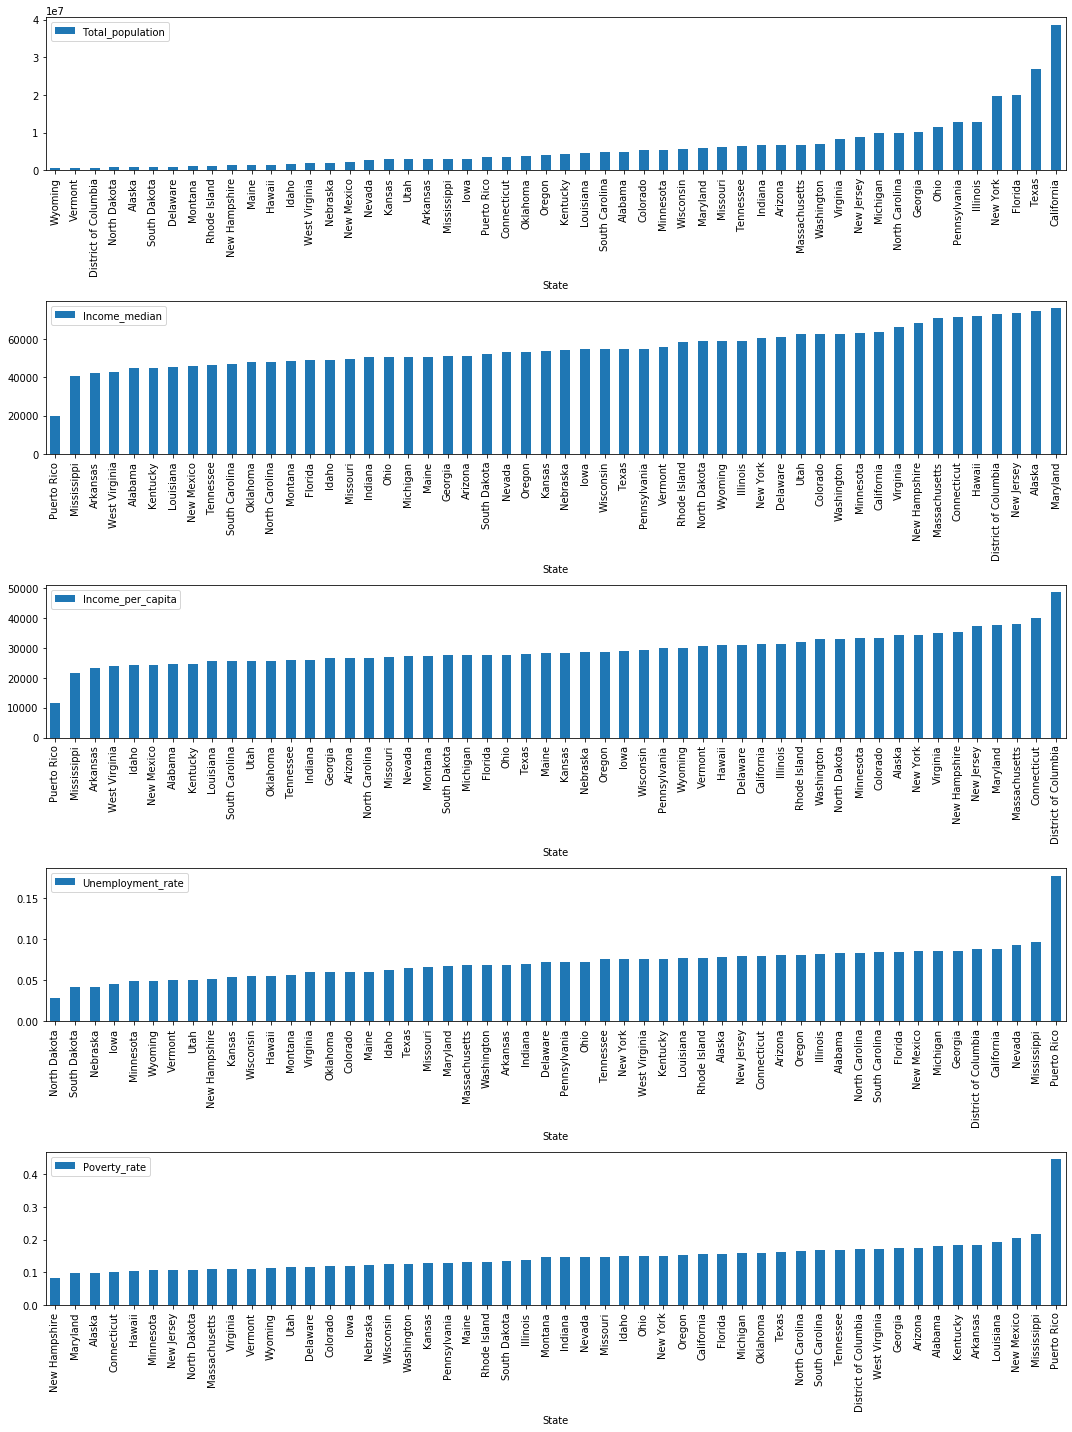

In [8]:
# Visualization via bar plots: population, median income, per capita income, poverty rate, unemployment rate

plt.subplot(511)
fig_population = census_df['Total_population'].sort_values().plot(kind='bar',figsize=(15,20), legend=True)

plt.subplot(512)
fig_income = census_df['Income_median'].sort_values().plot(kind='bar', figsize=(15,20), legend=True)

plt.subplot(513)
fig_capita_income = census_df['Income_per_capita'].sort_values().plot(kind='bar',figsize=(15,20), legend=True)

plt.subplot(514)
fig_unemploy_rate = census_df['Unemployment_rate'].sort_values().plot(kind='bar',figsize=(15,20), legend=True)

plt.subplot(515)
fig_unemploy_rate = census_df['Poverty_rate'].sort_values().plot(kind='bar',figsize=(15,20), legend=True)

plt.tight_layout()

In [9]:
import gmaps
from config import gkey
gmaps.configure(api_key=gkey)

In [10]:
# Settings for gmap figure
figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto',
}

# locations of all states
state_coords = census_df.loc[:, ['Latitude', 'Longitude']]

In [11]:
# Population heatmap
# markers = gmaps.marker_layer(state_coords)
# gmap_fig.add_layer(markers)

gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
population_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Total_population'],max_intensity = census_df['Total_population'].max(),
                                  dissipating=False, point_radius=3, opacity=0.5)
gmap_fig.add_layer(population_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))

In [12]:
# median income heatmap
gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
income_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Income_median'],max_intensity = census_df['Income_median'].max(),
                                  dissipating=False, point_radius=3, opacity=0.3)

gmap_fig.add_layer(income_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))

In [13]:
# per_capita_income heatmap
gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
per_capita_income_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Income_per_capita'],max_intensity = census_df['Income_per_capita'].max(),
                                  dissipating=False, point_radius=3, opacity=0.3)
gmap_fig.add_layer(per_capita_income_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))

In [14]:
# Unemployment_rate heatmap
gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
unemploy_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Unemployment_rate'], max_intensity = census_df['Unemployment_rate'].max(),
                                  dissipating=False, point_radius=4, opacity=0.6)

gmap_fig.add_layer(unemploy_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))

In [15]:
# poverty rate heatmap
gmap_fig = gmaps.figure(figure_layout,map_type='HYBRID')
poverty_layer = gmaps.heatmap_layer(state_coords, weights = census_df['Poverty_rate'],max_intensity = census_df['Poverty_rate'].max(),
                                  dissipating=False, point_radius=4, opacity=0.6)

gmap_fig.add_layer(poverty_layer)
gmap_fig

Figure(layout=FigureLayout(height='420px'))